In [12]:
!pip install geffnet
!pip install torchsummary
!pip install timm

You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [13]:
import geffnet
from torchsummary import summary
from torchvision import datasets, transforms
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import sys
from timm.optim.radam import RAdam

In [14]:
torch.manual_seed(0)
use_GPU = torch.cuda.is_available()
device = torch.device("cuda" if use_GPU else "cpu")
if use_GPU:
    torch.cuda.manual_seed(0)
    print('Device: ' + str(device))
    print('GPU: ' + str(torch.cuda.get_device_name(0)))
else:
    print("Using GPU: {}".format(use_GPU))

Device: cuda
GPU: Tesla V100-SXM2-16GB


In [15]:
def ImageProcessing():
    transform = transforms.Compose([transforms.Resize(224), transforms.CenterCrop(224),
                                    transforms.ToTensor(), transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))])

    train_dat = datasets.CIFAR100(root=sys.path[0] + "/data/CIFAR100", train=True, download=True, transform=transform)

    train_loader = DataLoader(train_dat, batch_size=32, shuffle=False, num_workers=2)

    test_dat = datasets.CIFAR100(root=sys.path[0] + '/data/CIFAR100', train=False, download=True, transform=transform)

    test_loader = torch.utils.data.DataLoader(test_dat, batch_size=1, shuffle=False, num_workers=2)

    return train_loader, test_loader




In [16]:
def training(model, train_loader, optimizer, criterion, epoch):
    training_loss = 0
    model.train()
    bi = 200

    for batch_idx, (inputs, targets) in enumerate(train_loader):

        inputs = inputs.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)

        loss = criterion(outputs, targets)

        loss.backward()

        optimizer.step()

        training_loss += loss.item()

        if batch_idx % bi == bi-1:  # print every 2000 mini-batches
            print('[epoch: %d, batch: %5d] loss: %.3f' % (epoch + 1, batch_idx + 1, training_loss / bi))
            training_loss = 0.0


In [17]:
def testing(model, test_loader, criterion):
    test_loss = 0.0
    correct = 0
    total = 0
    model.eval()

    with torch.no_grad():

        for inputs, targets in test_loader:
          
            inputs = inputs.to(device)

            targets = targets.to(device)

            outputs = model(inputs)

            test_loss += criterion(outputs, targets).item()

            _, predicted = torch.max(outputs.data, 1)

            correct += (predicted == targets).sum().item()

            total += 1

    print("\nTest set: Average loss: {:.4f}, Accuracy: {:.4f}\n".format(test_loss / total,
                                                                        correct / len(test_loader.dataset)))
    return test_loss / total, correct / len(test_loader.dataset)

In [18]:
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [19]:
def fine_tuning(model):

    epochs = 40

    test_acc = []
    test_loss = []

    model.to(device)

    # optimizer = torch.optim.RMSprop(params_to_update, lr = 0.0001, weight_decay =1e-5)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.99, weight_decay=1e-5)

    reduce_lr = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=1)

    train_loader, test_loader = ImageProcessing()

    criterion = torch.nn.CrossEntropyLoss()

    for epoch in range(epochs):
        print_learning_rate(optimizer, epoch+1)

        training(model, train_loader, optimizer, criterion, epoch)

        loss, acc = testing(model, test_loader, criterion)

        test_loss.append(loss)

        test_acc.append(acc)

        reduce_lr.step(loss)


    fig, (ax1,ax2) = plt.subplots(1,2)
    ax1.plot(list(range(1,epochs+1)), test_acc)
    ax1.set(xlabel='epochs', ylabel='test accuracy')
    ax2.plot(list(range(1,epochs+1)), test_loss)
    ax2.set(xlabel='epochs', ylabel='test loss')
    fig.tight_layout(pad=4.0)
    ax2.set_xticks(np.arange(1, epochs+1, step=1))
    ax1.set_xticks(np.arange(1, epochs+1, step=1))

    plt.show()
    
    return model


In [20]:
def adjust_learning_rate(lr, optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by 0.97 every 2.4 epochs"""
    lr = lr * (0.97 ** (epoch // 2))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

def print_learning_rate(optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    for param_group in optimizer.param_groups:
        print("Epoch: [{}] Current learning rate (lr) = {}".format(
                                                    epoch, param_group['lr']))

In [21]:
def main(md):

    # classes = ('plane', 'car', 'bird', 'cat',
    #            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

    # classes = (
    # 'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 
    # 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 
    # 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 
    # 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 
    # 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 
    # 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion',
    # 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse',
    # 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear',
    # 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine',
    # 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose',
    # 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake',
    # 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table',
    # 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout',
    # 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman',
    # 'worm')

    train_loader, test_loader = ImageProcessing()
    
    # print(len(classes))
    # imageshow(train_loader, classes)

    momentum = 0.9
    epochs = 20
    decay = 1e-5
    lr = 0.001

    model = md.to(device)

    summary(model,(3,224,224),batch_size=10)

    criterion = nn.CrossEntropyLoss()
    
    # optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=decay)
    
    optimizer = optim.RAdam(model.parameters(), lr=lr, weight_decay = decay)

    # reduce_lr = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)
    reduce_lr = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=2)

    for epoch in range(epochs):
        print_learning_rate(optimizer,epoch+1)
        training(model, train_loader, optimizer, criterion, epoch)
        loss,_ = testing(model, test_loader, criterion)
        # adjust_learning_rate(lr, optimizer,epoch+1)
        reduce_lr.step(loss)

    # PATH = './cifar_net.pth'
    # torch.save(model.state_dict(), PATH)


Using cache found in /root/.cache/torch/hub/rwightman_gen-efficientnet-pytorch_master


['efficientnet_b0', 'efficientnet_b1', 'efficientnet_b2', 'efficientnet_b3', 'efficientnet_es', 'fbnetc_100', 'mixnet_l', 'mixnet_m', 'mixnet_s', 'mixnet_xl', 'mnasnet_a1', 'mnasnet_b1', 'mobilenetv3_rw', 'spnasnet_100', 'tf_efficientnet_b0', 'tf_efficientnet_b0_ap', 'tf_efficientnet_b0_ns', 'tf_efficientnet_b1', 'tf_efficientnet_b1_ap', 'tf_efficientnet_b1_ns', 'tf_efficientnet_b2', 'tf_efficientnet_b2_ap', 'tf_efficientnet_b2_ns', 'tf_efficientnet_b3', 'tf_efficientnet_b3_ap', 'tf_efficientnet_b3_ns', 'tf_efficientnet_b4', 'tf_efficientnet_b4_ap', 'tf_efficientnet_b4_ns', 'tf_efficientnet_b5', 'tf_efficientnet_b5_ap', 'tf_efficientnet_b5_ns', 'tf_efficientnet_b6', 'tf_efficientnet_b6_ap', 'tf_efficientnet_b6_ns', 'tf_efficientnet_b7', 'tf_efficientnet_b7_ap', 'tf_efficientnet_b7_ns', 'tf_efficientnet_b8', 'tf_efficientnet_b8_ap', 'tf_efficientnet_cc_b0_4e', 'tf_efficientnet_cc_b0_8e', 'tf_efficientnet_cc_b1_8e', 'tf_efficientnet_el', 'tf_efficientnet_em', 'tf_efficientnet_es', 'tf_ef

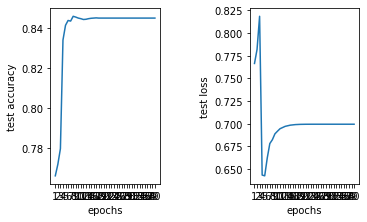

GenEfficientNet(
  (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): SwishJit()
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): SwishJit()
        (se): SqueezeExcite(
          (avg_pool): AdaptiveAvgPool2d(output_size=1)
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SwishJit()
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act2): Identity

In [22]:
print(torch.hub.list('rwightman/gen-efficientnet-pytorch'))

md = geffnet.create_model('efficientnet_b0',pretrained=True)

md.classifier = torch.nn.Linear(1280,100,bias=False)

fine_tuning(md)

# main(md)